https://github.com/csoren66/Potato_leaf_disease_Detection/blob/main/Potato_disease_detection.ipynb

Importing dependencies

In [23]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Set all the Constants

In [24]:

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 10

Import data into tensorflow dataset object

In [25]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/deepr/Desktop/SGP 2/Potato Images", 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [26]:
class_names = dataset.class_names
class_names = ['Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy']


In [27]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 2 2 1 2 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1]


Visualize some of the images from our dataset

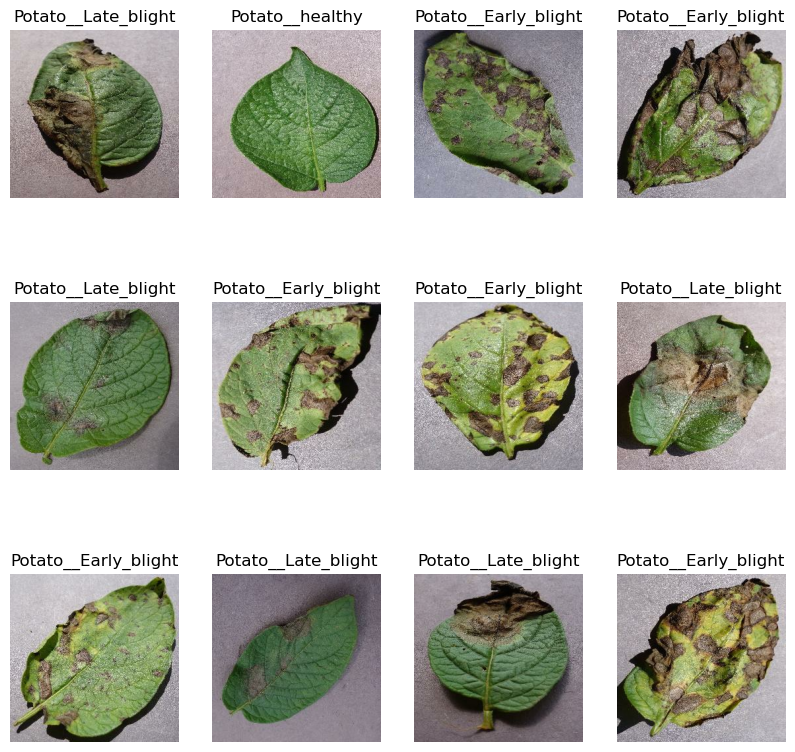

In [28]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,1+i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training.
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [29]:
len(dataset)

68

In [30]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [31]:
train_ds = dataset.take(54)
len(train_ds)

54

In [32]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [33]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [34]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [35]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [36]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert  (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  val_size = int(val_split * ds_size)
    
  train_ds = ds.take(train_size)    
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
    
  return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds)

54

In [39]:
len(val_ds)

6

In [40]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

Building the Model

Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.



In [42]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])
     

Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [43]:
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [44]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [47]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [48]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 79s 1s/step - loss: 0.9161 - accuracy: 0.4907 - val_loss: 0.8546 - val_accuracy: 0.4635
Epoch 2/10
54/54 [==============================] - 70s 1s/step - loss: 0.7236 - accuracy: 0.6713 - val_loss: 0.5037 - val_accuracy: 0.7812
Epoch 3/10
54/54 [==============================] - 72s 1s/step - loss: 0.4241 - accuracy: 0.8206 - val_loss: 0.4509 - val_accuracy: 0.8177
Epoch 4/10
54/54 [==============================] - 74s 1s/step - loss: 0.3431 - accuracy: 0.8519 - val_loss: 0.2948 - val_accuracy: 0.8646
Epoch 5/10
54/54 [==============================] - 72s 1s/step - loss: 0.2504 - accuracy: 0.8964 - val_loss: 0.1919 - val_accuracy: 0.9115
Epoch 6/10
54/54 [==============================] - 71s 1s/step - loss: 0.1768 - accuracy: 0.9340 - val_loss: 0.2076 - val_accuracy: 0.9115
Epoch 7/10
54/54 [==============================] - 74s 1s/step - loss: 0.2229 - accuracy: 0.9051 - val_loss: 0.2302 - val_accuracy: 0.9219
Epoch 8/10
54/54 [==

In [49]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 317ms/step - loss: 0.1488 - accuracy: 0.9258


You can see above that we get 89.06% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [50]:
scores

[0.14882603287696838, 0.92578125]

Scores is just a list containing loss and accuracy value

In [51]:
history

In [52]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [54]:
type(history.history['loss'])

list

In [55]:
len(history.history['loss'])

10

In [56]:
history.history['loss'][:5]

[0.9161375761032104,
 0.7235556840896606,
 0.4240580201148987,
 0.34311458468437195,
 0.2504216134548187]

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Run prediction on a sample image

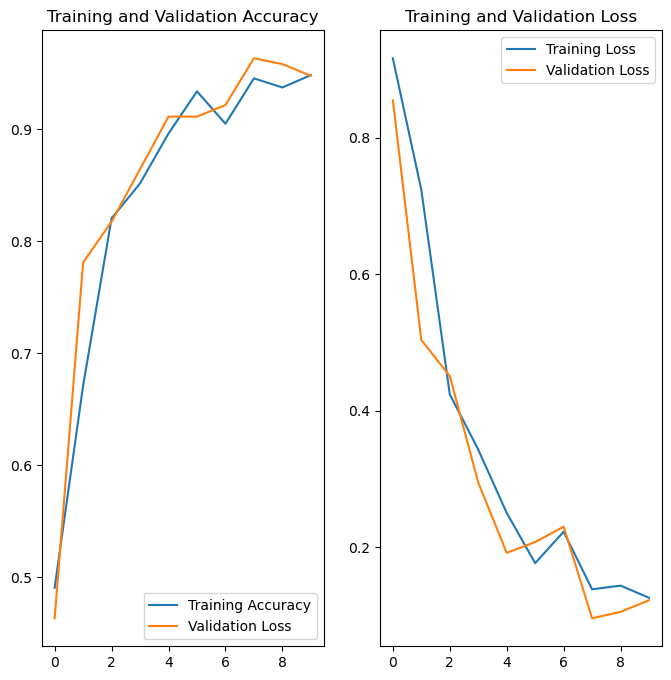

In [58]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato__Early_blight
1/1 [==============================] - 1s 548ms/step
predicted label: Potato__Early_blight


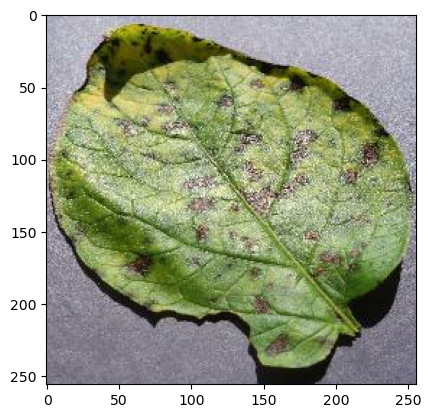

In [59]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 57ms/step


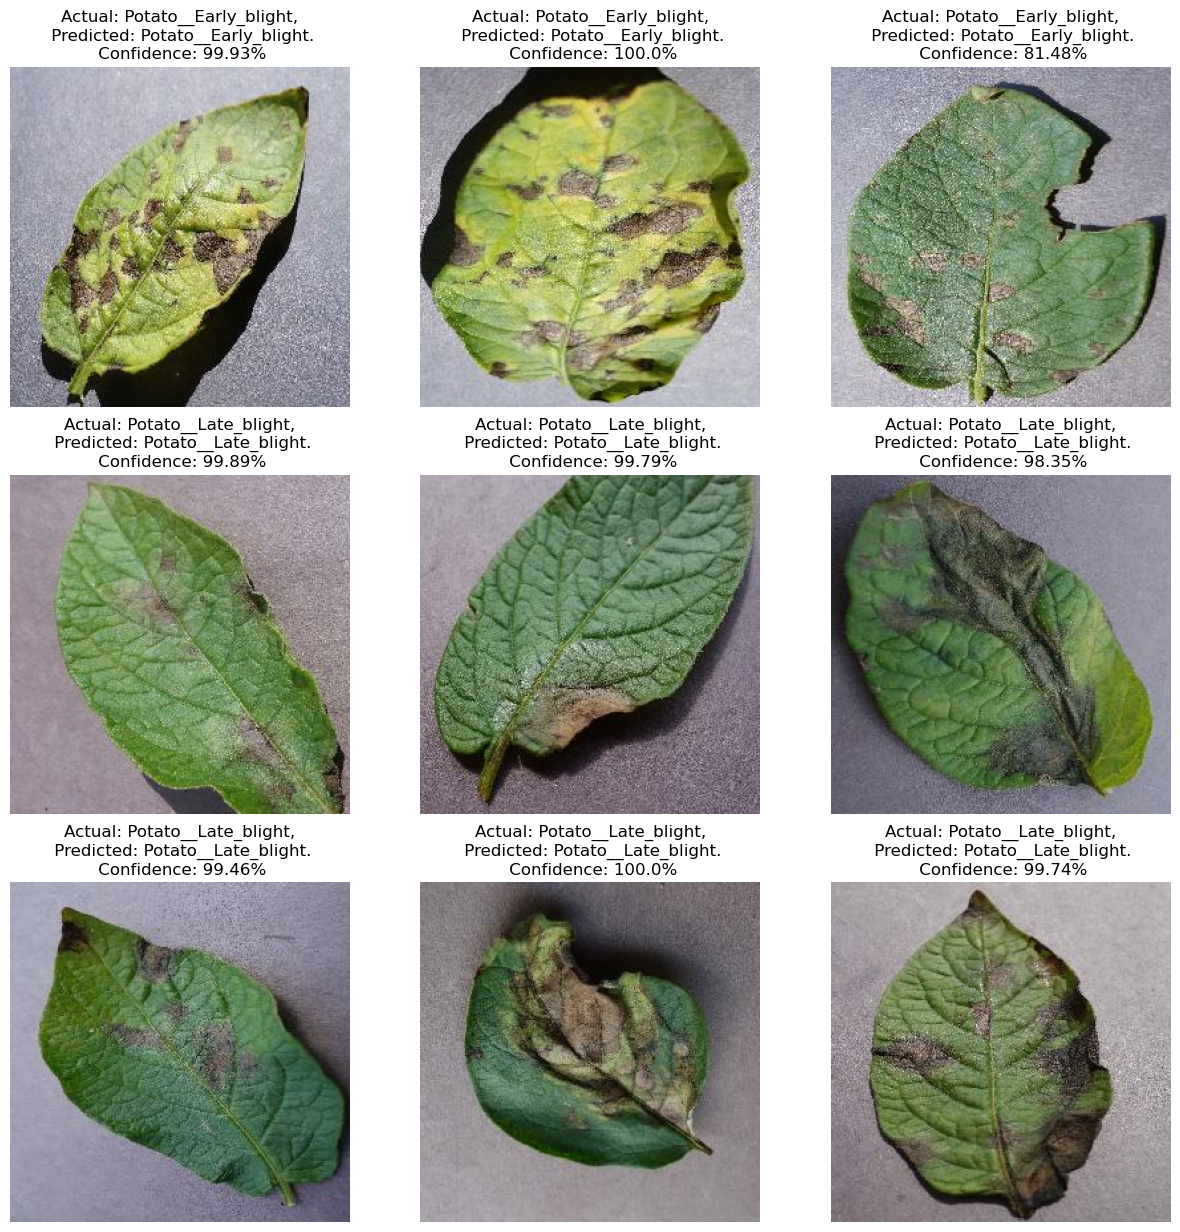

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Let's save our model 

In [62]:

# it will save the model
model.save('final_model.h5')